<a href="https://colab.research.google.com/github/ccg-esb-lab/MDR_IS_Model/blob/main/MonodGillespieIS_parametrization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Inference for the Stochastic IS Model

This notebook fits strain-specific parameters from experimental data, including Monod growth rates
(μ_max, K_S), antibiotic susceptibility parameters, and mutation/transposition rates from fluctuation
assays. These calibrated parameters are used throughout the simulations.


## Set experimental parameters

In [1]:
strainIDs = ["K253", "K168", "K037", "K241", "K209"]  # Species IDs
species_colors=['orange','blue', 'purple', 'green',  'black']

#strainID='K253'
#strainID='K168'
#strainID='K037'
#strainID='K241'
strainID='K209' #Strain to fit


# Define parameters for each mutation-transposition level
num_mutationsSNP = 3  # Number of mutation levels
num_mutationsIS = 3  # Number of transposition levels
segregation_rate=1e-7

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
antibiotic_concentration = 0.0  # No antibiotic for this run
B0=1e8
od2cells = 1e9

Amax=0.4

exportPKL=True

In [2]:
import os
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import pickle
import copy
from scipy.optimize import curve_fit, minimize, differential_evolution
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from matplotlib.patches import Wedge
from pprint import pprint

### Clone GitHub Repository

In [3]:
##repo_url = "https://github.com/jorgEVOplasmids/MDR_ISs.git"
repo_url  = "https://github.com/ccg-esb-lab/MDR_IS_Model.git"
repo_name = "MDR_IS_Model"

if not Path(repo_name).exists():
  !git clone {repo_url}

REPO_ROOT = Path(repo_name).resolve()

Cloning into 'MDR_IS_Model'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 54 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 2.98 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [4]:
# Repository paths
pathCODE    = REPO_ROOT / "code"
pathPARAMS  = REPO_ROOT / "data"
pathFIGURES = REPO_ROOT / "figures"
pathSIM     = REPO_ROOT / f"runs"

print("pathCODE:", pathCODE)
print("pathPARAMS:", pathPARAMS)
print("pathFIGURES:", pathFIGURES)
print("pathSIM:", pathSIM)

# Ensure output directories exist
pathFIGURES.mkdir(parents=True, exist_ok=True)
pathSIM.mkdir(parents=True, exist_ok=True)

sys.path.append(str(pathCODE))
import MonodGillespieIS_multispecies as mg
print("Module loaded successfully!")

pathCODE: /content/MDR_IS_Model/code
pathPARAMS: /content/MDR_IS_Model/data
pathFIGURES: /content/MDR_IS_Model/figures
pathSIM: /content/MDR_IS_Model/runs
Module loaded successfully!


## Simple Model

In [5]:
def gillespie_bacterial_growth_batch(
    strains,
    initial_resource,
    simulation_time,
    antibiotic_concentration,
    dt=0.1,
    num_simulations=3
):
    """
    Batch-update simulation of growth under resource limitation and antibiotic killing.
    Returns the mean trajectory over several stochastic replicates.
    """

    all_t_values = []
    all_population_values = []
    all_R_values = []

    for _ in range(num_simulations):

        t = 0
        populations = [s["initial_population"] for s in strains]
        R = initial_resource

        t_hist = [t]
        pop_hist = [populations[:]]
        R_hist = [R]

        while t < simulation_time:

            if sum(populations) <= 0 or R <= 0:
                t += dt
                t_hist.append(t)
                pop_hist.append(populations[:])
                R_hist.append(R)
                continue

            # Birth events
            births = [
                np.random.poisson(
                    s["birth_rate"]
                    * populations[i]
                    * (R / (R + s["K"]))
                    * dt
                )
                for i, s in enumerate(strains)
            ]

            # Antibiotic-dependent death events
            deaths = [
                np.random.poisson(
                    s["death_rate"]
                    * populations[i]
                    * (antibiotic_concentration / (antibiotic_concentration + s["A_half"]))
                    * dt
                )
                for i, s in enumerate(strains)
            ]

            # Population update
            for i in range(len(populations)):
                populations[i] += births[i] - deaths[i]

            # Resource depletion from births
            R -= sum(births[i] * strains[i]["c"] for i in range(len(strains)))

            populations = [max(0, p) for p in populations]
            R = max(0, R)

            t += dt
            t_hist.append(t)
            pop_hist.append(populations[:])
            R_hist.append(R)

        all_t_values.append(t_hist)
        all_population_values.append(pop_hist)
        all_R_values.append(R_hist)

    all_t_values = np.array(all_t_values)
    all_population_values = np.array(all_population_values)
    all_R_values = np.array(all_R_values)

    mean_t = np.mean(all_t_values, axis=0)
    mean_pop = np.mean(all_population_values, axis=0)
    mean_R = np.mean(all_R_values, axis=0)

    return mean_t, mean_pop, mean_R


In [6]:
def plotSimulation(time_points, population_values, resource):
    """
    Plot population trajectories (wild-type and mutants) and resource depletion.
    Wild-type is shown in black; mutants use a Blues colormap.
    """

    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)

    num_strains = len(population_values[0])
    cmap = plt.get_cmap("Blues")

    # Population trajectories
    for i in range(num_strains):
        color = "black" if i == 0 else cmap(i / num_strains)
        linestyle = "-" if i == 0 else "--"
        axes[0].plot(
            time_points,
            [p[i] for p in population_values],
            color=color,
            linestyle=linestyle,
            label=f"Strain {i}"
        )

    axes[0].set_xlabel("Time (hours)", fontsize=14)
    axes[0].set_ylabel("Population", fontsize=14)
    axes[0].set_yscale("log")
    axes[0].tick_params(axis="both", labelsize=12)

    # Resource trajectory
    axes[1].plot(time_points, resource, color="orange")
    axes[1].set_xlabel("Time (hours)", fontsize=14)
    axes[1].set_ylabel("Resource concentration", fontsize=14)
    axes[1].tick_params(axis="both", labelsize=12)
    axes[1].set_ylim([0, 1.1])

    plt.show()


## Determination of Monod parameters

In [7]:


fileName="DO_kinetic.txt"
# Define the full file path
file_path = os.path.join(pathPARAMS, fileName)

# Verify the file path
print("Full file path:", file_path)

# Example metadata for strains
strain_metadata = {
    "A": ["K241", "", "K241", "", "K241", "", "K241", "", "K241", "", "K241", "", "K241"],
    "B": ["", "K241", "", "K241", "", "K241", "", "K241", "", "K241", "", "K241", ""],
    "C": ["K037", "", "K037", "", "K037", "", "K037", "", "K037", "", "K037", ""],
    "D": ["", "K037", "", "K037", "", "K037", "", "K037", "", "K037", "", "K037", ""],
    "E": ["K209", "", "K209", "", "K209", "", "K209", "", "K209", "", "K209", ""],
    "F": ["", "K209", "", "K209", "", "K209", "", "K209", "", "K209", "", "K209", ""],
    "G": ["K168", "", "K168", "", "K168", "", "K168", "", "K168", "", "K168", ""],
    "H": ["", "K168", "", "K168", "", "K168", "", "K168", "", "K168", "", "K168", ""],
    "I": ["", "", "", "", "", "K253", "", "K253", "", "K253", "", "K253", ""],
    "J": [ "K253", "", "", "", "", "", "", "", "", "", "", "", ""],
    "K": [ "", "", "", "K253", "", "K253", "", "K253", "", "K253", "", "K253", ""]
}

# Example metadata for plasmid condition
plasmid_metadata = {
    "A": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "B": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "C": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "D": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "E": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "F": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "G": ["p", "", "p", "", "p", "", "p", "", "p", "", "p", ""],
    "H": ["", "0", "", "0", "", "0", "", "0", "", "0", "", "0", ""],
    "I": [ "", "", "", "", "", "0", "", "0", "", "0", "", "0", ""],
    "J": [ "0", "", "", "", "", "", "", "", "", "", "", "", ""],
    "K": [ "", "", "", "p", "", "p", "", "p", "", "p", "", "p", ""]
}

# Convert to structured dictionary
plate_metadata = {}
for row in "ABCDEFGHIJK":
    for col in range(1, 13):
        well = f"{row}{col}"
        strain = strain_metadata[row][col-1]
        plasmid = plasmid_metadata[row][col-1]

        # Only store if there's valid data
        if strain:
            plate_metadata[well] = {
                "strain": strain,
                "plasmid_condition": plasmid
            }

for well in ["A1", "B2", "C3", "D4", "E5", "F6", "I10",  "I12", "I6", "I8", "J1", "K10", "K12", "K4", "K6", "K8"]:
    if well in plate_metadata:
        print(f"{well}: {plate_metadata[well]}")
    else:
        print(f"{well}: Empty")

Full file path: /content/MDR_IS_Model/data/DO_kinetic.txt
A1: {'strain': 'K241', 'plasmid_condition': 'p'}
B2: {'strain': 'K241', 'plasmid_condition': '0'}
C3: {'strain': 'K037', 'plasmid_condition': 'p'}
D4: {'strain': 'K037', 'plasmid_condition': '0'}
E5: {'strain': 'K209', 'plasmid_condition': 'p'}
F6: {'strain': 'K209', 'plasmid_condition': '0'}
I10: {'strain': 'K253', 'plasmid_condition': '0'}
I12: {'strain': 'K253', 'plasmid_condition': '0'}
I6: {'strain': 'K253', 'plasmid_condition': '0'}
I8: {'strain': 'K253', 'plasmid_condition': '0'}
J1: {'strain': 'K253', 'plasmid_condition': '0'}
K10: {'strain': 'K253', 'plasmid_condition': 'p'}
K12: {'strain': 'K253', 'plasmid_condition': 'p'}
K4: {'strain': 'K253', 'plasmid_condition': 'p'}
K6: {'strain': 'K253', 'plasmid_condition': 'p'}
K8: {'strain': 'K253', 'plasmid_condition': 'p'}


In [8]:
def get_wells_by_strain_condition(plate_metadata, strain, condition):
    """
    Returns a list of wells that match a specific strain and plasmid condition.

    Parameters:
    plate_metadata (dict): Dictionary containing well metadata.
    strain (str): The strain name to filter (e.g., "K241").
    condition (str): The plasmid condition to filter (e.g., "p" or "0").

    Returns:
    list: Wells that match the specified strain and plasmid condition.
    """
    matching_wells = [
        well for well, data in plate_metadata.items()
        if data["strain"] == strain and data["plasmid_condition"] == condition
    ]
    return matching_wells

In [9]:
# Read the file with proper delimiter handling
df_od = pd.read_csv(file_path, delimiter=r"\s+", decimal=",", engine='python')

# Rename first column for clarity
df_od.rename(columns={df_od.columns[0]: "Well"}, inplace=True)

# Extract time points (convert to float hours)
time_labels = df_od.columns[1:]
time_hours = np.array([int(t.split(":")[0]) + int(t.split(":")[1]) / 60 for t in time_labels], dtype=float)

# Convert OD values to numeric format
od_values = df_od.iloc[:, 1:].replace(',', '.', regex=True).astype(float).to_numpy()

# Extract well labels
well_labels = df_od["Well"].to_numpy()

# Print shapes to confirm correctness
print(f"Time (hours) shape: {time_hours.shape}")
print(f"OD Values shape: {od_values.shape}")


Time (hours) shape: (145,)
OD Values shape: (106, 145)


In [10]:
def get_od_data_by_strain_condition(
    plate_metadata, od_values, well_labels, time_hours, strain, condition
):
    """
    Return mean and standard deviation of OD trajectories for wells matching a
    specific strain and plasmid condition.
    """

    wells = get_wells_by_strain_condition(plate_metadata, strain, condition)

    # Find rows in od_values that correspond to these wells
    well_indices = [
        np.where(well_labels == w)[0][0] for w in wells if w in well_labels
    ]

    if not well_indices:
        print(f"No wells found for strain {strain} under condition {condition}")
        return None, None, time_hours

    selected_od = od_values[well_indices, :]

    mean_od = np.mean(selected_od, axis=0)
    std_od = np.std(selected_od, axis=0)

    return mean_od, std_od, time_hours


def convert_od_to_cell_density(mean_od, std_od, od2cells=1e9):
    """
    Convert OD measurements to cell densities.
    """
    return mean_od * od2cells, std_od * od2cells


In [11]:
def objective_time_series(
    params,
    time_hours,
    od_experimental,
    initial_resource,
    simulation_time,
    strains_guess
):
    """
    Objective function for fitting birth rate, resource half-saturation, and
    consumption rate to OD time series data.
    """

    birth_rate, half_saturation_resource, consumption_rate = params

    # Work on a copy to avoid mutating the input template
    strains = copy.deepcopy(strains_guess)
    strains[0]["birth_rate"] = birth_rate
    strains[0]["c"] = consumption_rate
    strains[0]["K"] = half_saturation_resource

    sim_time, population_values, _ = gillespie_bacterial_growth_batch(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentration=0.0  # no antibiotic during fitting
    )

    # First strain only; convert simulated density to OD (1e9 cells → 1 OD)
    od_simulated = np.array([pop[0] for pop in population_values])

    # Interpolate simulation to experimental sampling times
    od_simulated_interp = np.interp(time_hours, sim_time, od_simulated)

    # Sum of squared residuals
    error = np.sum((od_simulated_interp - od_experimental) ** 2)

    return error


In [12]:
condition = "p"

# Retrieve data
mean_od_p, std_od_p, time_hours_p = get_od_data_by_strain_condition(plate_metadata, od_values, well_labels, time_hours, strainID, condition)

# Convert OD to cell densities
mean_cell_densities_p, std_cell_densities_p = convert_od_to_cell_density(mean_od_p, std_od_p)

# Initial guesses
birth_rate_guess_p = 1.0
consumption_rate_guess_p = 5e-9
half_saturation_resource_guess_p = 0.5
initial_guess_p = [birth_rate_guess_p, half_saturation_resource_guess_p, consumption_rate_guess_p]


# Use the optimized parameters for plasmid-bearing strains
strains_guess_p = [
    {
        'birth_rate': birth_rate_guess_p,
        'death_rate': 0.0,  # tmp
        'initial_population': B0,
        'K': half_saturation_resource_guess_p,
        'c': consumption_rate_guess_p,
        'A_half': 0.1  #
    }
]

# Define parameter bounds
bounds_p = [(0.8, 1.4), (0.4, 0.6), (1e-10, 20e-8)]

# Run optimization
result_p = differential_evolution(
    objective_time_series, bounds_p,
    args=(time_hours_p, mean_cell_densities_p, initial_resource, simulation_time, strains_guess_p),
    popsize=50, maxiter=1000, tol=1e-3
)

# Extract optimized parameters
optimized_birth_rate_p, optimized_half_saturation_resource_p, optimized_consumption_rate_p = result_p.x

# Print optimized results
print("\nOptimization Results (Plasmid-Bearing):")
print(f"Optimized birth_rate_p: {optimized_birth_rate_p:.3f}")
print(f"Optimized consumption_rate_p: {optimized_consumption_rate_p:.3e}")
print(f"Optimized half_saturation_resource_p: {optimized_half_saturation_resource_p:.3e}")
print(f"Final Objective Value (Error from Target): {result_p.fun:.2e}")

# Run simulation with optimized parameters
optimized_strains_p = copy.deepcopy(strains_guess_p)
optimized_strains_p[0]['birth_rate'] = optimized_birth_rate_p
optimized_strains_p[0]['c'] = optimized_consumption_rate_p
optimized_strains_p[0]['K'] = optimized_half_saturation_resource_p

sim_time_p, final_population_values_p, _ = gillespie_bacterial_growth_batch(
    strains=optimized_strains_p,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentration=0.0
)

# Convert simulated population to cell densities
optimized_cell_densities_p = np.array([pop[0] for pop in final_population_values_p])


# Use the optimized parameters for strains_0
strains_p = [
    {
        'birth_rate': optimized_birth_rate_p,
        'death_rate': 0.1,  # Keeping the original death rate unless specified otherwise
        'initial_population': B0,
        'K': optimized_half_saturation_resource_p,
        'c': optimized_consumption_rate_p,
        'A_half': 0.5  # Keeping this parameter unchanged as it's not optimized here
    }
]


Optimization Results (Plasmid-Bearing):
Optimized birth_rate_p: 0.800
Optimized consumption_rate_p: 1.094e-09
Optimized half_saturation_resource_p: 6.000e-01
Final Objective Value (Error from Target): 8.85e+17


In [13]:
condition = "0"

# Retrieve data
mean_od_0, std_od_0, time_hours_0 = get_od_data_by_strain_condition(plate_metadata, od_values, well_labels, time_hours, strainID, condition)

# Convert OD to cell densities
mean_cell_densities_0, std_cell_densities_0 = convert_od_to_cell_density(mean_od_0, std_od_0)

# Initial guesses
birth_rate_guess_0 = 1.0
consumption_rate_guess_0 = 5e-9
half_saturation_resource_guess_0 = 0.5
initial_guess_0 = [birth_rate_guess_0, half_saturation_resource_guess_0, consumption_rate_guess_0]


# Use the optimized parameters for plasmid-free strains
strains_guess_0 = [
    {
        'birth_rate': birth_rate_guess_0,
        'death_rate': 0.0,  # tmp
        'initial_population': B0,
        'K': half_saturation_resource_guess_0,
        'c': consumption_rate_guess_0,
        'A_half': 0.1  #
    }
]

# Define parameter bounds
bounds_0 = [(0.8, 1.4), (0.4, 0.6), (1e-10, 20e-8)]

# Run optimization
result_0 = differential_evolution(
    objective_time_series, bounds_0,
    args=(time_hours_0, mean_cell_densities_0, initial_resource, simulation_time, strains_guess_0),
    popsize=50, maxiter=1000, tol=1e-3
)

# Extract optimized parameters
optimized_birth_rate_0, optimized_half_saturation_resource_0, optimized_consumption_rate_0 = result_0.x

# Print optimized results
print("\nOptimization Results (Plasmid-Free):")
print(f"Optimized birth_rate_0: {optimized_birth_rate_0:.3f}")
print(f"Optimized consumption_rate_0: {optimized_consumption_rate_0:.3e}")
print(f"Optimized half_saturation_resource_0: {optimized_half_saturation_resource_0:.3e}")
print(f"Final Objective Value (Error from Target): {result_0.fun:.2e}")

# Run simulation with optimized parameters
optimized_strains_0 = copy.deepcopy(strains_guess_0)
optimized_strains_0[0]['birth_rate'] = optimized_birth_rate_0
optimized_strains_0[0]['c'] = optimized_consumption_rate_0
optimized_strains_0[0]['K'] = optimized_half_saturation_resource_0

sim_time_0, final_population_values_0, _ = gillespie_bacterial_growth_batch(
    strains=optimized_strains_0,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentration=0.0
)

# Convert simulated population to cell densities
optimized_cell_densities_0 = np.array([pop[0] for pop in final_population_values_0])


# Use the optimized parameters for strains_0
strains_0 = [
    {
        'birth_rate': optimized_birth_rate_0,
        'death_rate': 0.1,  # Keeping the original death rate unless specified otherwise
        'initial_population': B0,
        'K': optimized_half_saturation_resource_0,
        'c': optimized_consumption_rate_0,
        'A_half': 0.1  # Keeping this parameter unchanged as it's not optimized here
    }
]


Optimization Results (Plasmid-Free):
Optimized birth_rate_0: 0.820
Optimized consumption_rate_0: 8.649e-10
Optimized half_saturation_resource_0: 6.000e-01
Final Objective Value (Error from Target): 6.55e+17


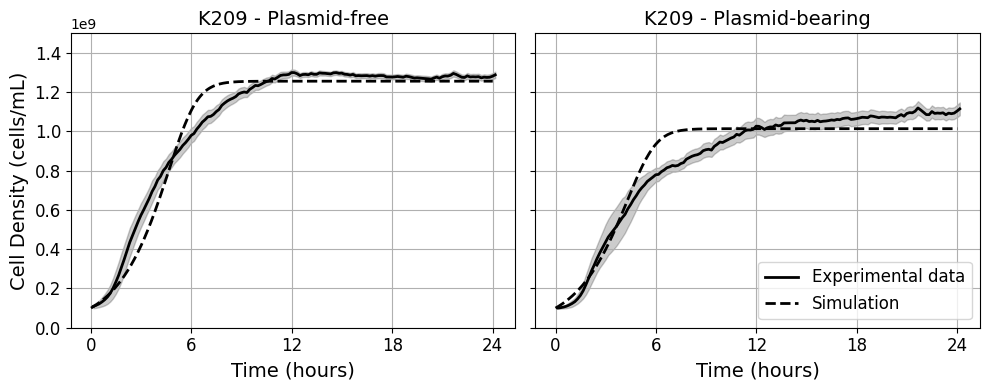

In [14]:
def plot_mean_std_cell_density(
    time_hours_0, mean_cell_densities_0, std_cell_densities_0,
    sim_time_0, optimized_cell_densities_0,
    time_hours_p, mean_cell_densities_p, std_cell_densities_p,
    sim_time_p, optimized_cell_densities_p,
    strainID, strainIDs, species_colors, ymax=1.5e9
):
    """
    Plot experimental (mean ± SD) and simulated cell densities for plasmid-free and
    plasmid-bearing conditions in side-by-side panels.
    """

    strain_index = strainIDs.index(strainID)
    strain_color = species_colors[strain_index]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # --- Plasmid-free ---
    ax0 = axes[0]
    ax0.plot(time_hours_0, mean_cell_densities_0, "-", color=strain_color, lw=2)
    ax0.fill_between(
        time_hours_0,
        mean_cell_densities_0 - std_cell_densities_0,
        mean_cell_densities_0 + std_cell_densities_0,
        color=strain_color,
        alpha=0.2
    )
    ax0.plot(sim_time_0, optimized_cell_densities_0, "--", color=strain_color, lw=2)

    ax0.set_xlabel("Time (hours)", fontsize=14)
    ax0.set_ylabel("Cell Density (cells/mL)", fontsize=14)
    ax0.set_title(f"{strainID} - Plasmid-free", fontsize=14)
    ax0.grid(True)
    ax0.set_xticks([0, 6, 12, 18, 24])
    ax0.tick_params(axis="both", labelsize=12)
    ax0.set_ylim([0, ymax])

    # --- Plasmid-bearing ---
    ax1 = axes[1]
    ax1.plot(time_hours_p, mean_cell_densities_p, "-", color=strain_color, lw=2,
             label="Experimental data")
    ax1.fill_between(
        time_hours_p,
        mean_cell_densities_p - std_cell_densities_p,
        mean_cell_densities_p + std_cell_densities_p,
        color=strain_color,
        alpha=0.2
    )
    ax1.plot(sim_time_p, optimized_cell_densities_p, "--", color=strain_color, lw=2,
             label="Simulation")

    ax1.set_xlabel("Time (hours)", fontsize=14)
    ax1.set_title(f"{strainID} - Plasmid-bearing", fontsize=14)
    ax1.grid(True)
    ax1.legend(fontsize=12, loc="lower right")
    ax1.set_xticks([0, 6, 12, 18, 24])
    ax1.tick_params(axis="both", labelsize=12)
    ax1.set_ylim([0, ymax])

    plt.tight_layout()
    plt.show()


plot_mean_std_cell_density(
    time_hours_0, mean_cell_densities_0, std_cell_densities_0,
    sim_time_0, optimized_cell_densities_0,
    time_hours_p, mean_cell_densities_p, std_cell_densities_p,
    sim_time_p, optimized_cell_densities_p,
    strainID, strainIDs, species_colors
)


In [15]:
def create_birth_rates(Nmuts, Nins, max_birth_rate, min_birth_rate):
    """
    Generates a (Nmuts × Nins) matrix where birth rates decline smoothly from
    (0,0) to (Nmuts-1, Nins-1).
    """
    birth_rates = np.zeros((Nmuts, Nins))
    span = max_birth_rate - min_birth_rate
    denom = Nmuts + Nins - 2  # ensures full gradient coverage

    for i in range(Nmuts):
        for j in range(Nins):
            birth_rates[i, j] = max_birth_rate - span * (i + j) / denom

    return birth_rates


# Construct birth-rate matrices for plasmid-free and plasmid-bearing cells
birth_rates_0 = create_birth_rates(
    num_mutationsSNP,
    num_mutationsIS,
    optimized_birth_rate_0,
    optimized_birth_rate_0 * 0.95
)

birth_rates_p = create_birth_rates(
    num_mutationsSNP,
    num_mutationsIS,
    optimized_birth_rate_p,
    optimized_birth_rate_p * 0.95
)


In [16]:
def create_consumption_rates(Nmuts, Nins, consumption_rate):
    """
    Create a consumption-rate matrix with the same value across all mutation and
    insertion levels.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    consumption_rate (float): Resource consumption rate applied uniformly.

    Returns:
    np.array: A Nmuts × Nins array of consumption rates.
    """
    return np.full((Nmuts, Nins), consumption_rate)


# Plasmid-free and plasmid-bearing consumption-rate matrices
consumption_rates_0 = create_consumption_rates(
    num_mutationsSNP, num_mutationsIS, optimized_consumption_rate_0
)

consumption_rates_p = create_consumption_rates(
    num_mutationsSNP, num_mutationsIS, optimized_consumption_rate_p
)


In [17]:
def create_half_saturation_resource(Nmuts, Nins, half_saturation_resource):
    """
    Create a half-saturation resource matrix with the same value for all
    mutation and insertion levels.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    half_saturation_resource (float): Half-saturation constant applied uniformly.

    Returns:
    np.array: Nmuts × Nins array of half-saturation values.
    """
    return np.full((Nmuts, Nins), half_saturation_resource)


# Plasmid-free and plasmid-bearing matrices
half_saturation_resource_rates_0 = create_half_saturation_resource(
    num_mutationsSNP, num_mutationsIS, optimized_half_saturation_resource_0
)

half_saturation_resource_rates_p = create_half_saturation_resource(
    num_mutationsSNP, num_mutationsIS, optimized_half_saturation_resource_p
)


## Parameterize drug resistance levels

In [18]:


# Load the CSV exported from Google Sheets
csv_path = pathPARAMS / "IS_data.csv"
df = pd.read_csv(csv_path)   # or dtype=str if you want everything as strings

# Ensure the IC90 column is numeric
df['IC90'] = pd.to_numeric(df['IC90'], errors='coerce')  # Convert and handle errors as NaN

# Drop rows with NaN values in IC90 if any
df = df.dropna(subset=['IC90'])

# Calculate the mean and standard deviation of IC90 for each modified strain
grouped = df.groupby('StrainID')['IC90'].agg(['mean', 'std']).reset_index()




In [19]:
def get_mean_IC90(strain_id):
    """
    Returns the mean IC90 for a specified strain ID.

    Parameters:
    strain_id (str): The strain ID to look up.

    Returns:
    float: Mean IC90 value for the specified strain ID, or None if the strain is not found.
    """
    # Filter the grouped DataFrame for the specified strain ID
    result = grouped[grouped['StrainID'] == strain_id]

    # Check if strain exists and return the mean IC90, else None
    if not result.empty:
        mean_ic90 = result['mean'].values[0]
        print(f"The mean IC90 for strain {strain_id} is: {mean_ic90}")
        return mean_ic90
    else:
        print(f"Strain {strain_id} not found in the data.")
        return None


strainID_p="%sp" % strainID
mean_ic90_0 = get_mean_IC90(strainID)
mean_ic90_p = get_mean_IC90(strainID_p)


The mean IC90 for strain K209 is: 0.1
The mean IC90 for strain K209p is: 0.1


In [20]:
def run_dose_response(
        strains,
        initial_resource,
        simulation_time,
        antibiotic_concentrations,
        toPlot=False
    ):
    """
    Run batch simulations over multiple antibiotic concentrations and
    return the final density for each concentration. Optionally plot
    full time-series curves.

    Parameters:
        strains (list of dict): Strain parameter dictionaries.
        initial_resource (float): Initial resource concentration.
        simulation_time (float): Duration of each simulation.
        antibiotic_concentrations (array-like): Drug concentrations.
        toPlot (bool): Plot OD trajectories if True.

    Returns:
        dict: Final density at each concentration.
    """
    final_ODs = {}

    if toPlot:
        norm = mcolors.Normalize(
            vmin=min(antibiotic_concentrations),
            vmax=max(antibiotic_concentrations)
        )
        cmap = cm.Reds
        plt.figure(figsize=(6, 4))

    for conc in antibiotic_concentrations:

        t_values, population_values, _ = gillespie_bacterial_growth_batch(
            strains,
            initial_resource,
            simulation_time,
            conc
        )

        OD_values = [np.sum(pop) for pop in population_values]
        final_ODs[conc] = OD_values[-1]

        if toPlot:
            color = "black" if conc == 0 else cmap(norm(conc))
            plt.plot(t_values, OD_values, color=color)

    if toPlot:
        plt.xlabel("Time (hours)", fontsize=14)
        plt.ylabel("Density", fontsize=14)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca())
        cbar.set_label("Antibiotic Concentration (µg/mL)", fontsize=12)

        plt.tight_layout()
        plt.show()

    return final_ODs



def computeIC(dose_response_results, IC, B0):
    """
    Estimate the inhibitory concentration producing IC% reduction
    relative to the drug-free net growth.

    Parameters:
        dose_response_results (dict): Final densities indexed by drug concentration.
        IC (float): Inhibition target (50 = IC50, 90 = IC90).
        B0 (float): Initial density.

    Returns:
        float: Estimated IC value, or -1 if inhibition is not achieved.
    """
    concentrations = np.array(sorted(dose_response_results.keys()))
    final_ODs = np.array([dose_response_results[c] for c in concentrations])

    net_growth = np.maximum(final_ODs - B0, 0)
    max_net = net_growth[0]
    target = max_net * (1 - IC / 100)

    if np.all(net_growth > target):
        return -1

    below = net_growth > target
    idx_above = np.argmax(~below)
    idx_below = idx_above - 1

    if idx_below < 0 or idx_above >= len(concentrations):
        return -1

    c1, c2 = concentrations[idx_below], concentrations[idx_above]
    y1, y2 = net_growth[idx_below], net_growth[idx_above]

    return c1 + (target - y1) * (c2 - c1) / (y2 - y1)



def plot_dose_response(dose_response_results, IC_concentration=None, IC_label="IC"):
    """
    Plot the final density as a function of antibiotic concentration.
    Optionally add a vertical marker for an IC value.

    Parameters:
        dose_response_results (dict): Final densities per concentration.
        IC_concentration (float or None): IC value to mark.
        IC_label (str): Label for the vertical IC line.
    """
    concentrations = sorted(dose_response_results.keys())
    final_ODs = [dose_response_results[c] for c in concentrations]

    plt.figure(figsize=(6, 4))
    plt.plot(concentrations, final_ODs, marker="o", color="black")

    plt.xlabel("Antibiotic Concentration", fontsize=14)
    plt.ylabel("Final Density", fontsize=14)
    plt.grid(False)
    plt.ylim([0, np.max(final_ODs) * 1.1])

    if IC_concentration is not None:
        plt.axvline(IC_concentration, color="red", linestyle="--",
                    label=f"{IC_label} = {IC_concentration:.3f}")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [21]:
def objective(params, target_IC90, strains,
              initial_resource, simulation_time, antibiotic_concentrations):
    """
    Objective function for minimizing the difference between simulated IC90
    and the target IC90.

    Parameters:
    - params: (death_rate, A_half)
    - target_IC90: Target IC90 value
    - strains: Strain parameter template
    - initial_resource: Initial resource concentration
    - simulation_time: Duration of the simulation
    - antibiotic_concentrations: Range of drug concentrations

    Returns:
    - Absolute difference between simulated and target IC90
    """
    death_rate, A_half = params

    strains[0]['death_rate'] = death_rate
    strains[0]['A_half'] = A_half

    final_ODs = run_dose_response(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentrations=antibiotic_concentrations
    )

    simulated_IC90 = computeIC(final_ODs, IC=90, B0=B0)

    if simulated_IC90 == -1:
        return float('inf')

    return abs(simulated_IC90 - target_IC90)


In [22]:

target_IC90_p = get_mean_IC90(strainID+'p')
print("Target IC90_p:", target_IC90_p)

# Range of concentrations
antibiotic_concentration_range = np.linspace(0, Amax, 50)

# Define bounds for each parameter (modify as necessary)
bounds = [(0.0001, 20), (0.0001, 20)]

# Objective function
result_p = differential_evolution(
    objective,
    bounds=bounds,
    args=(target_IC90_p, strains_p, initial_resource, simulation_time, antibiotic_concentration_range),
    tol=1e3,  # Can adjust as necessary
    strategy='best1bin',
    popsize=20
)

# Extract optimized parameters
optimized_death_rate_p, optimized_A_half_p = result_p.x

optimized_death_rate_p=5
optimized_A_half_p=10

print("Optimized death_rate_p:", optimized_death_rate_p)
print("Optimized A_half_p:", optimized_A_half_p)

# Compute IC90 with optimized parameters
strains_p[0]['death_rate'] = optimized_death_rate_p
strains_p[0]['A_half'] = optimized_A_half_p
dose_response_results_p = run_dose_response(
    strains=strains_p,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentrations=antibiotic_concentration_range,
    toPlot=False
)
computed_IC90_p = computeIC(dose_response_results_p, IC=90, B0=B0)
print("Computed IC90_p with optimized parameters:", computed_IC90_p)


The mean IC90 for strain K209p is: 0.1
Target IC90_p: 0.1


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Optimized death_rate_p: 5
Optimized A_half_p: 10
Computed IC90_p with optimized parameters: 0.16935412854591714


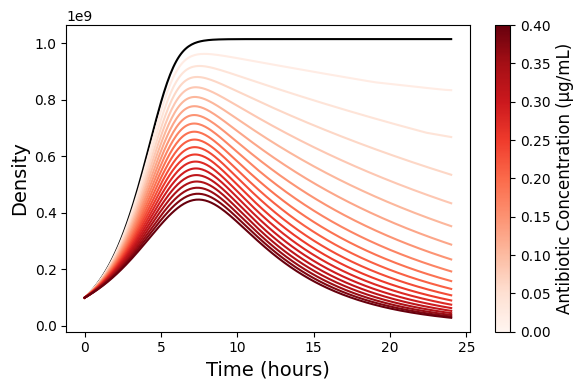

IC90: 0.16938497624426635


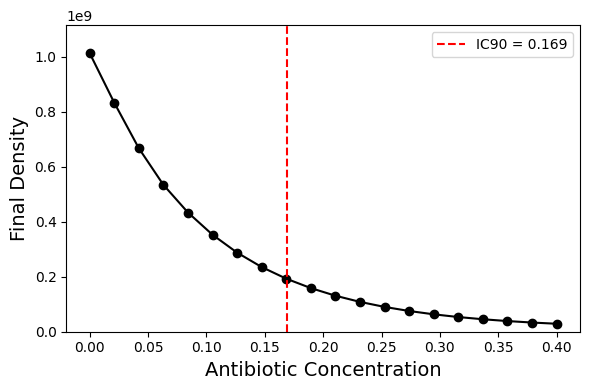

In [23]:


# Use the optimized parameters for strains_0
strains_p = [
    {
        'birth_rate': optimized_birth_rate_p,
        'initial_population': B0,
        'K': optimized_half_saturation_resource_p,
        'c': optimized_consumption_rate_p,
        'death_rate': optimized_death_rate_p,
        'A_half': optimized_A_half_p
    }
]

antibiotic_concentration_range = np.linspace(0, Amax, 20)  # Example range of concentrations from 0 to 1
final_ODs = run_dose_response(
    strains=strains_p,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentrations=antibiotic_concentration_range,
    toPlot=True
)

# Compute IC90 (90% inhibition)
IC90 = computeIC(final_ODs, IC=90, B0=B0)
print("IC90:", IC90)

# Plot dose-response curve with IC90 annotation
plot_dose_response(final_ODs, IC_concentration=IC90, IC_label="IC90")


For plasmid-free

In [24]:

target_IC90_0 = get_mean_IC90(strainID)
print("Target IC90_0:", target_IC90_0)

# Range of concentrations
antibiotic_concentration_range = np.linspace(0, Amax, 50)

# Define bounds for each parameter (modify as necessary)
bounds = [(0.001, 10), (0.001, 10)]  # Example bounds for death_rate and A_half
# Objective function remains the same as in your current setup
result_0 = differential_evolution(
    objective,
    bounds=bounds,
    args=(target_IC90_0, strains_0, initial_resource, simulation_time, antibiotic_concentration_range),
    tol=1e4,  # Can adjust as necessary
    strategy='best1bin',
    popsize=20
)

# Extract optimized parameters
optimized_death_rate_0, optimized_A_half_0 = result_0.x

optimized_death_rate_0=5
optimized_A_half_0=10

print("Optimized death_rate_0:", optimized_death_rate_0)
print("Optimized A_half_0:", optimized_A_half_0)

strains_0 = [
    {
        'birth_rate': optimized_birth_rate_0,
        'initial_population': B0,
        'K': optimized_half_saturation_resource_0,
        'c': optimized_consumption_rate_0,
        'death_rate': optimized_death_rate_0,
        'A_half': optimized_A_half_0
    }
]

dose_response_results_0 = run_dose_response(
    strains=strains_0,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentrations=antibiotic_concentration_range,
    toPlot=False
)
computed_IC90_0 = computeIC(dose_response_results_0, IC=90, B0=B0)
print("Computed IC90_0 with optimized parameters:", computed_IC90_0)


The mean IC90 for strain K209 is: 0.1
Target IC90_0: 0.1
Optimized death_rate_0: 5
Optimized A_half_0: 10
Computed IC90_0 with optimized parameters: 0.18354164124023142


In [25]:
def create_death_rates(Nmuts, Nins, max_death_rate, min_death_rate):
    """
    Creates a death_rates matrix where death rates progressively decrease from
    the top-left (0,0) corner toward the bottom-right (Nmuts-1, Nins-1) corner.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    max_death_rate (float): The death rate at position (0,0) (highest death rate).
    min_death_rate (float): The death rate at position (Nmuts-1, Nins-1) (lowest death rate).

    Returns:
    np.array: A 2D array representing death_rates with a gradient of resistance.
    """
    # Initialize the death_rates matrix
    death_rates = np.zeros((Nmuts, Nins))

    # Calculate step size for the decrease in death rate across the matrix
    for i in range(Nmuts):
        for j in range(Nins):
            # Calculate linear interpolation based on position
            rate = max_death_rate - (max_death_rate - min_death_rate) * (i + j) / (Nmuts + Nins - 2)
            death_rates[i, j] = rate

    return death_rates

# Plasmid-bearing
max_death_rate_p = optimized_death_rate_p  # Death rate for mutation level 0 (wild-type)
min_death_rate_p = optimized_death_rate_p/num_mutationsSNP  # Death rate for the highest mutation level (most resistant)
death_rates_p = create_death_rates(num_mutationsSNP, num_mutationsIS, max_death_rate_p, min_death_rate_p)
print("Death Rates_p:\n", death_rates_p)

# Plasmid-free
max_death_rate_0 = optimized_death_rate_0  # Death rate for mutation level 0 (wild-type)
min_death_rate_0 = optimized_death_rate_0/num_mutationsSNP  # Death rate for the highest mutation level (most resistant)
death_rates_0 = create_death_rates(num_mutationsSNP, num_mutationsIS, max_death_rate_0, min_death_rate_0)
print("Death Rates_0:\n", death_rates_0)

Death Rates_p:
 [[5.         4.16666667 3.33333333]
 [4.16666667 3.33333333 2.5       ]
 [3.33333333 2.5        1.66666667]]
Death Rates_0:
 [[5.         4.16666667 3.33333333]
 [4.16666667 3.33333333 2.5       ]
 [3.33333333 2.5        1.66666667]]


In [26]:

def create_half_saturation_antibiotic(Nmuts, Nins, half_saturation_antibiotic):
    """
    Creates a flat half_saturation_antibiotic matrix where the half-saturation antibiotics value is the same across
    all mutation and insertion levels.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    half_saturation_antibiotic (float): The constant half-saturation antibiotics value for all levels.

    Returns:
    np.array: A 2D array representing flat half_saturation_antibiotic values.
    """
    # Create the half_saturation_antibiotic matrix filled with the same value across all entries
    half_saturation_matrix = np.full((Nmuts, Nins), half_saturation_antibiotic)

    return half_saturation_matrix

half_saturation_antibiotic_0 = optimized_A_half_0  # Constant half-saturation for plasmid-free strains
half_saturation_antibiotic_p = optimized_A_half_p  # Constant half-saturation for plasmid-bearing strains

# Create the half_saturation_resource matrices
half_saturation_antibiotic_rates_0 = create_half_saturation_antibiotic(num_mutationsSNP, num_mutationsIS, half_saturation_antibiotic_0)
half_saturation_antibiotic_rates_p = create_half_saturation_antibiotic(num_mutationsSNP, num_mutationsIS, half_saturation_antibiotic_p)


## Mutation rates

In [27]:
df_muts = pd.read_csv(pathPARAMS / "IS_data.csv", dtype=str)
df_muts = df_muts.dropna(how='all').dropna(axis=1, how='all')

print(df_muts.head())

df_muts['SNP_rate'] = pd.to_numeric(df_muts['SNP_rate'], errors='coerce')
df_muts['IS1_rate'] = pd.to_numeric(df_muts['IS1_rate'], errors='coerce')

df_muts = df_muts.dropna(subset=['SNP_rate', 'IS1_rate'])


def get_mutation_rates(strain_id):
    """
    Returns (SNP_rate, IS1_rate) for a given strain_id.
    """
    row = df_muts[df_muts['StrainID'] == strain_id]

    if row.empty:
        print(f"Strain {strain_id} not found.")
        return None, None

    snp = row['SNP_rate'].values[0]
    is1 = row['IS1_rate'].values[0]

    print(f"SNP_rate for {strain_id}: {snp}")
    print(f"IS1_rate for {strain_id}: {is1}")

    return snp, is1


snp_rate_0, is1_rate_0 = get_mutation_rates(strainID)
snp_rate_p, is1_rate_p = get_mutation_rates(f"{strainID}p")


  Antibiotic Strain     ODmax StrainID IC90  SNP_rate  IS1_rate
0  Colistina   K209  1.30E+09     K209  0.1  1.52E-08  1.69E-09
1  Colistina   K209  1.11E+09    K209p  0.1  1.21E-08  5.18E-08
2  Colistina   K241  1.24E+09     K241  0.1  3.57E-09  1.25E-08
3  Colistina   K241  1.35E+09    K241p  0.1  5.29E-09  8.82E-09
4  Colistina   K037  1.29E+09     K037  0.1  1.12E-08  0.00E+00
SNP_rate for K209: 1.52e-08
IS1_rate for K209: 1.69e-09
SNP_rate for K209p: 1.21e-08
IS1_rate for K209p: 5.18e-08


In [28]:

# Function to create the mu_list with linearly increasing mutation rates based on transpositions
def create_mu_list_linear(Nmuts, Nins, base_rate, max_mu):
    """
    Creates a mu_list with values increasing linearly with the number of transpositions.

    Parameters:
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    base_rate (float): Minimum mutation rate when transpositions are 0.
    max_mu (float): Maximum mutation rate achievable.

    Returns:
    np.array: A 2D array representing mu_list.
    """
    # Calculate the slope for linear increase
    slope = (max_mu - base_rate) / (Nins - 1) if Nins > 1 else 0

    # Calculate mutation rates based on the linear formula
    transpositions = np.arange(Nins)
    mu_values = base_rate + slope * transpositions

    # Create the mu_list matrix
    mu_list = np.tile(mu_values, (Nmuts, 1))

    return mu_list


# Generate the mutation rates matrix (p)
base_rate_p = snp_rate_p      # Base mutation rate
max_mu_p = snp_rate_p #snp_rate_p * (num_mutationsSNP)  # Maximum mutation rate
mu_list_p = create_mu_list_linear(num_mutationsSNP, num_mutationsIS, base_rate_p, max_mu_p)


# Generate the mutation rates matrix (0)
base_rate_0 = snp_rate_0      # Base mutation rate
max_mu_0 = snp_rate_0 #snp_rate_0 * (num_mutationsSNP)  # Maximum mutation rate
mu_list_0 = create_mu_list_linear(num_mutationsSNP, num_mutationsIS, base_rate_0, max_mu_0)


## Parameterize transposition rates

In [29]:


def create_flat_tau_list(Nmuts, Nins, base_rate):
    """
    Creates a flat tau_list with a constant transposition rate across all levels.

    Parameters:
    Nmuts (int): Number of mutation levels (rows).
    Nins (int): Number of transposition levels (columns).
    base_rate (float): Constant transposition rate for all elements in the matrix.

    Returns:
    np.array: A 2D array representing a flat tau_list.
    """
    # Create the tau_list matrix filled with base_rate
    tau_list = np.full((Nmuts, Nins), base_rate)

    return tau_list

tau_list_p = create_flat_tau_list(num_mutationsSNP, num_mutationsIS, is1_rate_p)
print("Tau List:\n", tau_list_p)

tau_list_0 = create_flat_tau_list(num_mutationsSNP, num_mutationsIS, is1_rate_0)
print("Tau List:\n", tau_list_0)


Tau List:
 [[5.18e-08 5.18e-08 5.18e-08]
 [5.18e-08 5.18e-08 5.18e-08]
 [5.18e-08 5.18e-08 5.18e-08]]
Tau List:
 [[1.69e-09 1.69e-09 1.69e-09]
 [1.69e-09 1.69e-09 1.69e-09]
 [1.69e-09 1.69e-09 1.69e-09]]


In [30]:
# Generate data_IS dictionary from df
data_IS = {
    'strainID': df['StrainID'].str.replace('p', '', regex=False).tolist(),  # Remove 'p' for species name
    'nIS1_genome': [1 if not sid.endswith('p') else 3 for sid in df['StrainID']],  # Assign 1 or 3 based on 'p'
    'IS1_rate': df['IS1_rate'].astype(float).tolist()  # Convert IS1_rate to float
}

# Filter the dataframe for the target strain
filtered_df = df[df['StrainID'].str.replace('p', '', regex=False) == strainID]

# Generate the filtered dictionary
filtered_data_IS = {
    'strainID': filtered_df['StrainID'].str.replace('p', '', regex=False).tolist(),
    'nIS1_genome': [1 if not sid.endswith('p') else 3 for sid in filtered_df['StrainID']],
    'IS1_rate': filtered_df['IS1_rate'].astype(float).tolist()
}


## Export parameters

In [31]:

# Plasmid-free strains
strains_0 = []
for i in range(num_mutationsSNP):
    for j in range(num_mutationsIS):
        strain = {
            'strainID': strainID,
            'segregation_rate': segregation_rate,
            'birth_rate': birth_rates_0[i, j],
            'consumption_rate': consumption_rates_0[i, j],
            'half_saturation_resource': half_saturation_resource_rates_0[i, j],
            'mutation_rate': mu_list_0[i, j] ,
            'transposition_rate': tau_list_0[i,j],
            'death_rate': death_rates_0[i, j],
            'half_saturation_antibiotic': half_saturation_antibiotic_rates_0[i, j],  # Distinct value for resource limitation per transposition level
        }
        strains_0.append(strain)

# Plasmid-bearing strains
strains_p = []
for i in range(num_mutationsSNP):
    for j in range(num_mutationsIS):
        strain = {
            'strainID': strainID,
            'segregation_rate': segregation_rate,
            'birth_rate': birth_rates_p[i, j],
            'consumption_rate': consumption_rates_p[i, j],
            'half_saturation_resource': half_saturation_resource_rates_p[i, j],
            'mutation_rate': mu_list_p[i, j] ,
            'transposition_rate': tau_list_p[i,j],
            'death_rate': death_rates_p[i, j],
            'half_saturation_antibiotic':  half_saturation_antibiotic_rates_p[i, j]  # Distinct value for antibiotic susceptibility per mutation level
        }
        strains_p.append(strain)

In [32]:

if exportPKL:

    # Save plasmid-free strains (strains_0) to a .pkl file
    file_0='_params_%s_0.pkl'%strainID
    with open('%s%s'%(pathPARAMS, file_0), 'wb') as f:
        pickle.dump(strains_0, f)
    print("Plasmid-free parameters for strain %s saved successfully in: \n%s%s\n"%(strainID, pathPARAMS, file_0))

    # Save plasmid-bearing strains (strains_p) to a .pkl file
    file_p='_params_%s_p.pkl'%strainID
    with open('%s%s'%(pathPARAMS, file_p), 'wb') as f:
        pickle.dump(strains_p, f)
    print("Plasmid-bearing parameters for strain %s saved successfully in: \n%s%s\n"%(strainID, pathPARAMS, file_p))



Plasmid-free parameters for strain K209 saved successfully in: 
/content/MDR_IS_Model/data_params_K209_0.pkl

Plasmid-bearing parameters for strain K209 saved successfully in: 
/content/MDR_IS_Model/data_params_K209_p.pkl

